# Exploring Mazes with Novelty Search

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

TODO: background on mazes

## Setup

In [1]:
%pip install ribs[visualize] kheperax tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.flatten_util import ravel_pytree
from kheperax.tasks.config import KheperaxConfig
from kheperax.tasks.main import KheperaxTask
from tqdm import tqdm, trange

## Maze Environments with Kheperax

Kheperax is...

Accelerated in JAX...

For more info on Kheperax...

First, we set up JAX's random keys.

In [3]:
seed = 42
random_key = jax.random.PRNGKey(seed)
random_key, subkey = jax.random.split(random_key)

Next, we set up the Kheperax task.

In [4]:
# Define Task configuration
config_kheperax = KheperaxConfig.get_default()
config_kheperax.mlp_policy_hidden_layer_sizes = (8, 8)

# Create Kheperax Task.
(
    env,
    policy_network,
    scoring_fn,
) = KheperaxTask.create_default_task(
    config_kheperax,
    random_key=subkey,
)

scoring_fn = jax.jit(scoring_fn)

The networks in Kheperax are represented as pytrees, while pyribs typically expects 1D parameters. To be compatible with pyribs, we flatten the pytrees into vectors. Here, we pass a single batch of observations through the network in order to set up the `_array_to_pytree_fn` for un-flattening solution parameters, and also to retrieve the `solution_dim`.

TODO: edit

In [5]:
fake_batch = jnp.zeros(shape=(1, env.observation_size))
random_key, subkey = jax.random.split(random_key)
example_init_parameters = policy_network.init(subkey, fake_batch)
flattened_parameters, _array_to_pytree_fn = ravel_pytree(example_init_parameters)
solution_dim = len(flattened_parameters)
print("solution_dim:", solution_dim)

solution_dim: 138


We can also retrieve the bounds of the measure space (measures are referred to as behavior
descriptors in Kheperax).

In [6]:
min_bd, max_bd = env.behavior_descriptor_limits
bounds = [(min_bd[0], max_bd[0]), (min_bd[1], max_bd[1])]
print("bounds:", bounds)

bounds: [(0.0, 1.0), (0.0, 1.0)]


Finally, we define an evaluation function that... TODO

In [7]:
def evaluate(params, random_key):
    params = jnp.asarray(params)
    params_pytree = jax.vmap(_array_to_pytree_fn)(params)

    random_key, subkey = jax.random.split(random_key)
    objectives, measures, info, _ = scoring_fn(params_pytree, subkey)

    best_obj = 0.0
    worst_obj = -0.5
    objectives = (objectives - worst_obj) / (best_obj - worst_obj) * 100

    return np.asarray(objectives), np.asarray(measures), info

## Novelty Search in pyribs

### ProximityArchive

TODO

Note proximityarchive does not take in bounds

In [8]:
from ribs.archives import GridArchive, ProximityArchive

archive = ProximityArchive(solution_dim=solution_dim,
                           measure_dim=2,
                           k_neighbors=15,
                           novelty_threshold=0.01)
                           # k_neighbors=100,
                           # novelty_threshold=0.042)

result_archive = GridArchive(solution_dim=solution_dim,
                             dims=(100, 100),
                             ranges=bounds)

### Emitters

TODO

In [9]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        # Created earlier when we initialized the `_array_to_pytree_fn`.
        x0=np.asarray(flattened_parameters),
        sigma0=0.5,
        ranker="nov",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=30
    ) for _ in range(5)
]

### Scheduler

In [10]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

## Running Novelty Search

TODO: Talk about objective -- we need it for GridArchive?

In [11]:
total_itrs = 2500

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    solutions = scheduler.ask()

    random_key, subkey = jax.random.split(random_key)
    objectives, measures, info = evaluate(solutions, subkey)
    
    scheduler.tell(objectives, measures)

    # Logging.
    if itr % 50 == 0 or itr == total_itrs:
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Archive Size: {archive.stats.num_elites} "
                   f"Coverage: {result_archive.stats.coverage * 100:6.3f}%")

Iteration    50 | Archive Size: 2402 Coverage: 10.340%                             
Iteration   100 | Archive Size: 3217 Coverage: 13.770%                             
Iteration   150 | Archive Size: 3881 Coverage: 16.620%                             
Iteration   200 | Archive Size: 4476 Coverage: 18.830%                             
Iteration   250 | Archive Size: 5001 Coverage: 20.870%                             
Iteration   300 | Archive Size: 5345 Coverage: 22.250%                             
Iteration   350 | Archive Size: 5628 Coverage: 23.190%                             
Iteration   400 | Archive Size: 5925 Coverage: 24.080%                             
Iteration   450 | Archive Size: 6231 Coverage: 25.130%                             
Iteration   500 | Archive Size: 6475 Coverage: 25.960%                             
Iteration   550 | Archive Size: 6652 Coverage: 26.630%                             
Iteration   600 | Archive Size: 6814 Coverage: 27.240%                      

## Visualization

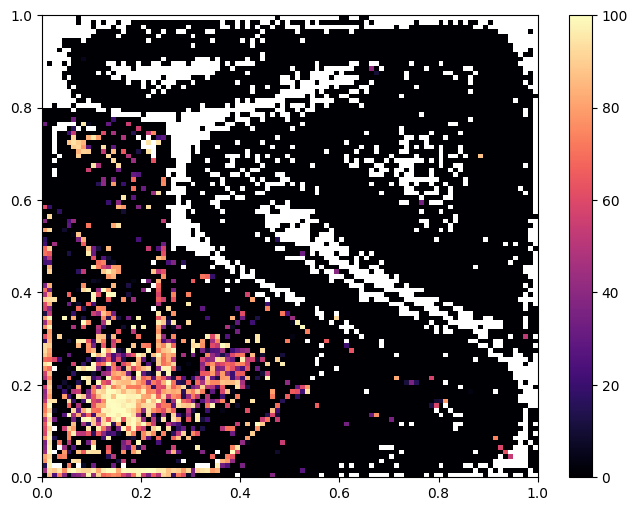

In [12]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_dds,
  title   = {Scaling CMA-MAE on the Sphere Benchmark},
  author  = {Bryon Tjanaka},
  journal = {pyribs.org},
  year    = {2023},
  url     = {https://docs.pyribs.org/en/stable/tutorials/cma_mae.html}
}
```